In [1]:
#Importing fastai library
!pip install -Uqq fastai
from fastai.vision.all import *

In [2]:
#path of the folder containing urls of Pets, present in fastai
path = untar_data(URLs.PETS)

In [3]:
#Total number of images in the loaded path
len(get_image_files(path))

14780

In [4]:
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [5]:
#Loading the contents of the path
path.ls()


(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_64.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_10.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_208.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_10.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_151.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_5.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_140.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_16.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_20.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_28.jpg')...]

In [7]:
fname = (path/"images").ls()[0]

In [8]:
#Regualr expression to get the label name from the image name
re.findall(r'(.+)_\d+.jpg$', fname.name)

['yorkshire_terrier']

The **DataBlock** api from Fastai library was used to provide the inputs to the model.

● ImageBlock and Category Block indicate that the input data is in the form of images and the corresponding label for the images is a category.

● The images will be fetched from the mentioned path.

● The splitting of data into training and testing sets will be done by the splitter function with the default splitting of 80-20. 80% of the data for training and 20% for testing phase.

● The label or the target category for the images are parsed using regular expressions from the image names.

● Some of the data augmentation techniques like zooming, flipping, resizing, etc are applied to the images which can be helpful for the model to generalize well on the new data.

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")

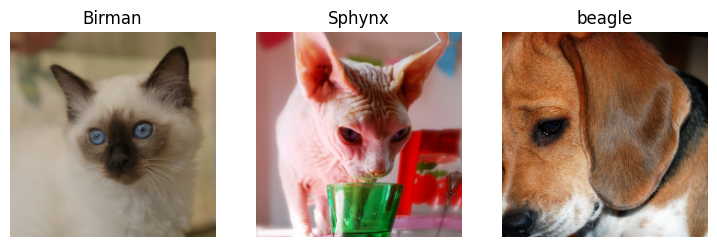

In [24]:
#Displaying the loaded images in the datablock from the first row
dls.show_batch(nrows=1, ncols=3)

In [ ]:
#Summary of the DataBlock
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_161.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bengal_161.jpg
    applying partial gives
      Bengal
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(1))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: 



*   Resnet34, a pre-trained model with a large set of images is used for this task.
*   Leveraging the knowledge of pre-trained model saves both model building time and resources like GPU.

*   Error rate is used as a metric to calculate the loss or difference between the predicted label and the actual label.

*   cnn_learner API from fastai library is used to create a CNN model with these inputs.






In [11]:

learn = cnn_learner(dls, resnet34, metrics=error_rate)


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 73.7MB/s]


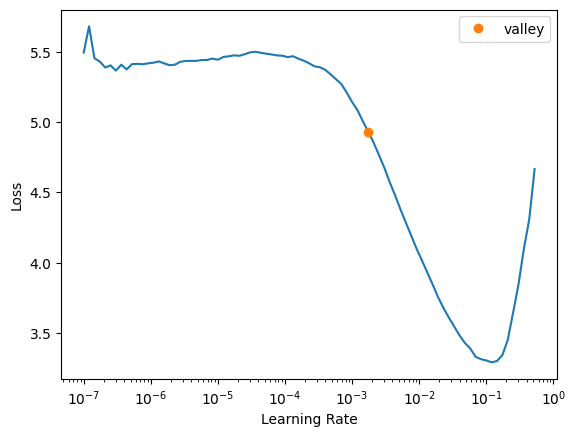

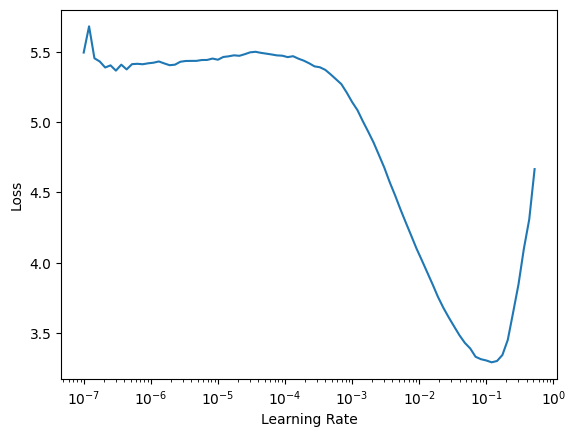

In [12]:
# Find the optimal learning rate
learn.lr_find()

# Plot the learning rate finder plot
learn.recorder.plot_lr_find()

In [13]:
learn.fine_tune(5, base_lr = 0.0001)

epoch,train_loss,valid_loss,error_rate,time
0,4.569341,2.447762,0.642084,01:05


epoch,train_loss,valid_loss,error_rate,time
0,3.120655,1.693163,0.432341,01:09
1,2.167182,0.883012,0.236130,01:12
2,1.500383,0.600490,0.166441,01:10
3,1.185673,0.520881,0.144790,01:14
4,1.079242,0.508212,0.140731,01:11


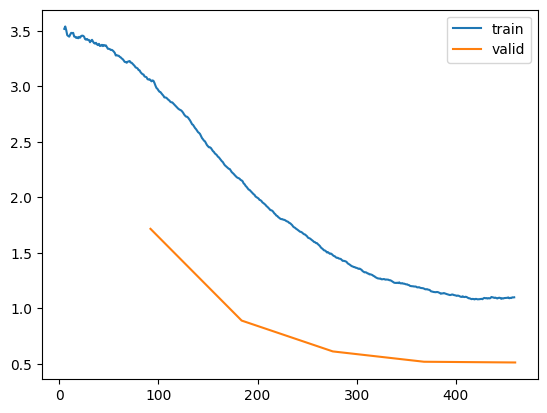

In [14]:
learn.recorder.plot_loss()

## Training Methods to Prevent Overtraining:

1. Early Stopping

In [14]:
from fastai.callback.tracker import EarlyStoppingCallback

learn = cnn_learner(dls, resnet34, metrics=error_rate, cbs=
    EarlyStoppingCallback(patience=3)
    )

learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.507752,0.327346,0.093369,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.470593,0.283178,0.086604,01:10
1,0.405139,0.290181,0.086604,01:11
2,0.287645,0.237284,0.069689,01:09
3,0.181675,0.204452,0.054127,01:09
4,0.127711,0.206295,0.054804,01:10


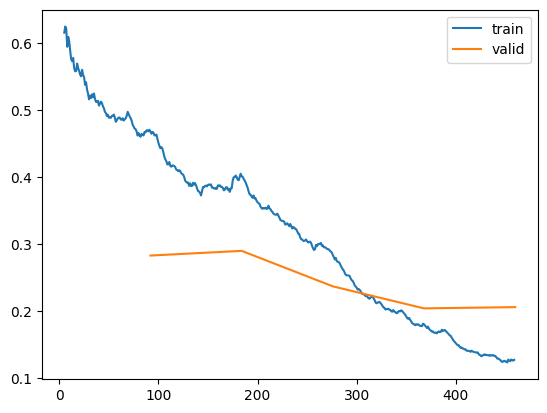

In [15]:
learn.recorder.plot_loss()

#Verify the model

Saving abc.jpeg to abc.jpeg


This is a american_bulldog 


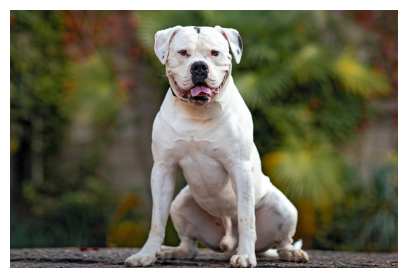

In [16]:

from google.colab import files
uploader = files.upload()

for img in uploader.items():
  uploadedImg = img[0]

img = PILImage.create(uploadedImg)
img.show()

label,_,probs = learn.predict(img)

print(f"This is a {label} ")


#Confusion Matrix

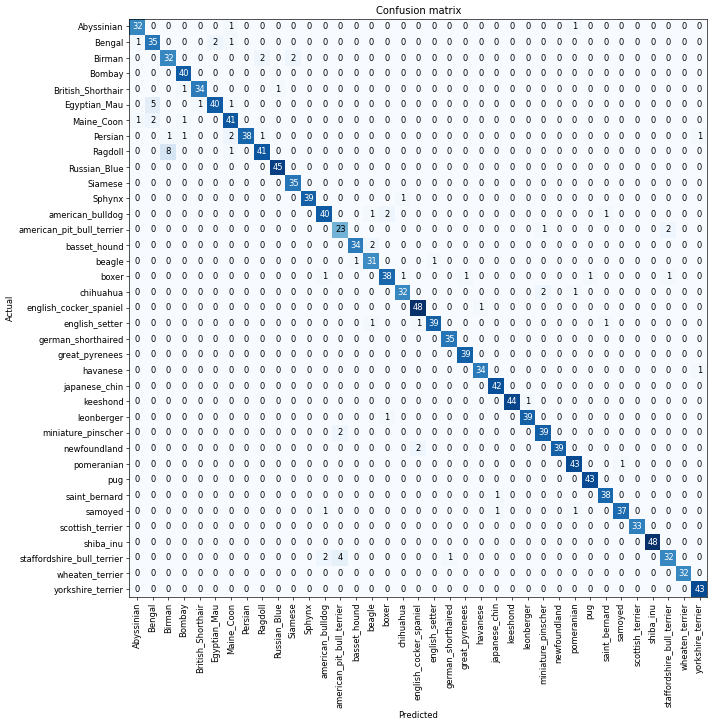

In [17]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.plot_top_losses(6)

In [18]:
learn.export('pet_classifier.pkl')

In [19]:
# Get a list of files matching the pattern
files = get_files(path, 'pet_classifier.pkl')

# Check if the list is not empty before accessing an element
if files:
    # Select the first file
    modelPath = files[0]
    print("Model file found:", modelPath)
else:
    print("No files matching the pattern found in the specified directory.")

No files matching the pattern found in the specified directory.


In [20]:
learn_inf = load_learner('pet_classifier.pkl')

In [21]:
import matplotlib.image as mpimg
learn_inf.predict(mpimg.imread(get_image_files(path)[0]))

('yorkshire_terrier',
 tensor(36),
 tensor([8.3521e-08, 1.8013e-09, 1.2155e-07, 3.8244e-10, 6.5715e-10, 5.0640e-10,
         7.8539e-09, 1.0609e-09, 1.2888e-09, 1.2224e-10, 2.8197e-08, 1.0670e-08,
         8.2059e-10, 6.5705e-10, 9.7240e-11, 5.2063e-09, 4.7519e-11, 2.0686e-08,
         1.0923e-08, 9.7765e-10, 5.3087e-10, 1.2943e-11, 2.5482e-07, 7.4787e-10,
         6.4708e-10, 1.5370e-09, 1.3387e-07, 6.7576e-11, 3.7803e-08, 8.5618e-11,
         1.0155e-10, 2.2953e-11, 4.7637e-09, 3.0140e-10, 2.1446e-10, 5.3864e-09,
         1.0000e+00]))

In [22]:
learn_inf.dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [23]:
from google.colab import files
files.download('pet_classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>